Pressure Loss calculation

In [1]:
import numpy as np

inc = np.array([0,0,45,45,90])
azi = np.array([0,15,30,30,45])
inc_rad = np.radians(inc)
azi_rad = np.radians(azi)
s = np.array([0,45,150,200,650])

dinc = np.diff(inc_rad)
dazi = np.diff(azi_rad)
ds = np.diff(s)

# Calculate the average of the inc and azi values at the intervals where the differences are calculated
inc_rad_avg = (inc_rad[:-1] + inc_rad[1:]) / 2
azi_rad_avg = (azi_rad[:-1] + azi_rad[1:]) / 2

t = np.column_stack([
    np.sin(inc_rad) * np.cos(azi_rad),
    np.sin(inc_rad) * np.sin(azi_rad),
    np.cos(inc_rad)
])

K = np.column_stack([
    np.cos(inc_rad_avg) * np.cos(azi_rad_avg) * (dinc / ds) - np.sin(inc_rad_avg) * np.sin(azi_rad_avg) * (dazi / ds),
    np.cos(inc_rad_avg) * np.sin(azi_rad_avg) * (dinc / ds) + np.sin(inc_rad_avg) * np.cos(azi_rad_avg) * (dazi / ds),
    -np.sin(inc_rad_avg) * (dinc / ds)
])

In [2]:
t_mag = np.linalg.norm(t, axis=1)
t_mag

array([1., 1., 1., 1., 1.])

In [3]:
K_s = np.linalg.norm(K, axis=1)
K_s

array([0.        , 0.00754059, 0.        , 0.00182622])

In [4]:
K

array([[ 0.        ,  0.        , -0.        ],
       [ 0.00601943,  0.0035261 , -0.00286247],
       [ 0.        ,  0.        , -0.        ],
       [ 0.00020268,  0.00083302, -0.00161247]])

In [5]:
t

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.12372436e-01, 3.53553391e-01, 7.07106781e-01],
       [6.12372436e-01, 3.53553391e-01, 7.07106781e-01],
       [7.07106781e-01, 7.07106781e-01, 6.12323400e-17]])

In [14]:
betta = np.arccos(np.sin(inc_rad[:-1])*np.sin(inc_rad[1:])*np.cos(np.diff(azi_rad)) + np.cos(inc_rad[:-1])*np.cos(inc_rad[1:]))
betta = np.nan_to_num(betta, nan=0.0)
RF = np.where(betta == 0, ds/2, ds/betta*np.tan(betta/2))
DLS = betta/ds

C:\Users\Elmir\AppData\Local\Temp\ipykernel_7636\707445729.py:1: RuntimeWarning: invalid value encountered in arccos
  betta = np.arccos(np.sin(inc_rad[:-1])*np.sin(inc_rad[1:])*np.cos(np.diff(azi_rad)) + np.cos(inc_rad[:-1])*np.cos(inc_rad[1:]))
C:\Users\Elmir\AppData\Local\Temp\ipykernel_7636\707445729.py:3: RuntimeWarning: divide by zero encountered in divide
  RF = np.where(betta == 0, ds/2, ds/betta*np.tan(betta/2))
C:\Users\Elmir\AppData\Local\Temp\ipykernel_7636\707445729.py:3: RuntimeWarning: invalid value encountered in multiply
  RF = np.where(betta == 0, ds/2, ds/betta*np.tan(betta/2))


In [1]:
from lib1.constants_opt import *
import numpy as np

/Users/elmir/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Web Extension extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
clc = Calculations(lengths=13000)
P_drop_inner , P_drop_outer, v_i, v_o = p_drop(
    Q=250,
    rho=clc.mud_density_ppg, 
    mu_p=clc.visc_p, 
    tao=clc.tao_y,
    D_o=clc.global_od_array, 
    D_i=clc.global_id_array,
    D_w=clc.global_hole_array,
    del_L=clc.global_length_array
)

ValueError: operands could not be broadcast together with shapes (419,) (418,) 

In [7]:
len(P_drop_outer)

545

In [11]:
sum(P_drop_outer)/len(P_drop_outer)

0.0269497283396357

In [12]:
sum(P_drop_inner)

3.1092846627245336

Effective tension

In [8]:
# Area_o = np.pi*(clc.global_hole_array**2 - clc.global_od_array**2)/4
Area_o = np.pi*(clc.global_od_array**2)/4
Area_i = np.pi*(clc.global_id_array**2)/4
C_tao_0 = (8 + 4*clc.global_eps + clc.global_eps**2)/8


Static_part = (12/231)*(Area_i-Area_o)*clc.mud_density_ppg*clc.gravity*clc.t_z
# Annular_part = (P_drop_outer*Area_o*clc.t_z_min)*(1+C_tao_0)
# Annular_part = (1+C_tao_0)*P_drop_outer*Area_o
Annular_part = (1+C_tao_0)*P_drop_outer*Area_o
Inertial_part = (12/231)*clc.mud_density_ppg*(v_o**2*Area_o - v_i**2*Area_i)*clc.DLS*clc.n_z

lin_force = -Annular_part + Inertial_part
fluid_force = np.flip(lin_force)
force_ave = fluid_force.sum()/len(fluid_force)
# total_force = np.cumsum(fluid_force)


In [4]:
fluid_force.sum()/len(fluid_force)

-2.9050048553926557

In [5]:
Static_part.sum()/len(Static_part)

-126.65696148671442

In [6]:
Inertial_part.sum()/len(Inertial_part)

-1.0160046322239014

In [8]:
Annular_part.sum()/len(Annular_part)

1.8890002231687542

In [4]:
from lib1.constants_opt import Calculations
from scipy.integrate import solve_ivp
import numpy as np

def trip_operation(F_b, ff, flowrate, length, operation='POOH'):
    clc = Calculations(lengths=length)
    new_force = fluid_force if flowrate != 0 else np.zeros_like(clc.MD[:-1])
    def dFds(s, F):
        # Interpolate the necessary values for the current s
        DLS_interp = np.interp(s, clc.MD[:-1], clc.DLS)
        n_z_interp = np.interp(s, clc.MD[:-1], clc.n_z)
        b_z_interp = np.interp(s, clc.MD[:-1], clc.b_z)
        t_z_interp = np.interp(s, clc.MD[:-1], clc.t_z)
        bw_pipe_interp = np.interp(s, clc.MD[:-1], clc.bw_pipe)
        fluid_interp = np.interp(s, clc.MD[:-1], new_force)

        # Calculate the contact force
        w_c = np.sqrt((F * DLS_interp + bw_pipe_interp * n_z_interp)**2 + (bw_pipe_interp * b_z_interp)**2)

        if operation == 'POOH':
            return -(bw_pipe_interp*t_z_interp + ff*w_c + fluid_interp)
        elif operation == 'RIH':
            return -(bw_pipe_interp*t_z_interp - ff*w_c + fluid_interp)
        elif operation == 'ROB':
            return -(bw_pipe_interp*t_z_interp + fluid_interp)
        else:
            raise ValueError("Unknown operation type specified.")

    s_span = [clc.MD[-1], clc.MD[0]]  # Span from the end to the start
    solution = solve_ivp(dFds,
                         s_span,
                         [F_b],
                         method='RK45',
                         t_eval=np.flip(clc.MD),
                         max_step=5,
                         rtol=0.001,
                         atol=0.001,
                         dense_output=True
    ) 
    
    return solution.y.flatten()

In [9]:
ROB470 = trip_operation(F_b=0, ff=0.15, flowrate=470, length=13000, operation='ROB')[-1]
ROB250 = trip_operation(F_b=0, ff=0.15, flowrate=250, length=13000, operation='ROB')[-1]
ROB0 = trip_operation(F_b=0, ff=0.15, flowrate=0, length=17000, operation='ROB')[-1]

In [10]:
ROB470, ROB250, ROB0

(272389.70483965543, 272389.70483965543, 296347.48780941573)

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig1 = make_subplots(rows=1, cols=1)

fig1.add_trace(go.Scatter(x=fluid_force, y=np.linspace(13000,0,len(fluid_force)), name='13k @ 470 gpm', line=dict(color='darkred', width=3, dash='dashdot')), row=1, col=1)

# Update the layout

fig1.update_layout(
    
    template= "none",
    title='Fluid Force for Various GPM Rates',
    title_font_size=24,
    xaxis=dict(
        title='Fluid Force [lbf]',
        titlefont_size=20
    ),
    yaxis=dict(
        title='Bit Depth [ft]',
        titlefont_size=20,
        autorange="reversed"
    ),
    legend=dict(
        traceorder='normal',
        font=dict(
            size=16,
        )
    ),
    height = 600,
    width = 1000
)

fig1.show()
# fig.write_html("Plot.html")

In [20]:
clc.DLS.tolist().index(0.008118177518585505)

362

In [22]:
clc.DLS[360:365]

array([0.00023394, 0.00623825, 0.00811818, 0.00068424, 0.00085438])

In [24]:
clc.MD[360:370]

array([11328.13816254, 11359.58939929, 11391.04063604, 11422.49187279,
       11453.94310954, 11485.39434629, 11516.84558304, 11548.29681979,
       11579.74805654, 11611.19929329])

In [19]:
newMD = np.flip(clc.MD).tolist()

In [20]:
newMD[1], newMD[39], newMD[-65]

(12999.000000000124, 11925.711660777497, 2015.7480314960667)

In [21]:
Annular_part = np.flip(Annular_part)

In [22]:
Inertial_part = np.flip(Inertial_part)

In [12]:
Annular_part

array([3.05914605, 3.05907654, 3.05903193, 3.05897814, 3.05891511,
       3.05884285, 3.05876136, 3.05867064, 3.0585707 , 3.05846152,
       3.05834311, 3.05821547, 3.0580786 , 3.05793251, 3.05777719,
       3.05761264, 3.05743886, 3.05725586, 3.05706363, 3.05686218,
       3.0566515 , 3.05643159, 3.05629134, 3.05625742, 3.05624378,
       3.05623041, 3.05621702, 3.05620359, 3.05619013, 3.05617664,
       3.05616313, 3.05614958, 3.05612004, 3.05604431, 3.05593646,
       3.05582606, 3.05571379, 3.05559967, 3.0554837 , 3.05536587,
       3.05524618, 3.05512464, 3.05500124, 3.05496923, 3.05505066,
       3.05515258, 3.05525377, 3.05535367, 3.05545228, 3.0555496 ,
       3.05564563, 3.05574036, 3.0558338 , 3.0559784 , 3.05620045,
       3.05644406, 3.05667822, 3.05690184, 3.05711492, 3.05731746,
       3.05750947, 3.05769093, 3.05786184, 3.05802222, 3.05817205,
       3.05828118, 3.05835058, 3.05841264, 3.0584721 , 3.0585291 ,
       3.05858365, 3.05863575, 3.05868539, 3.05873258, 3.05877

In [21]:
Annular_part[1]

1235.8085846845286

In [17]:
Annular_part[39]

3.0553658674154676

In [18]:
Annular_part[-65]

1.1507224905134679

In [24]:
Inertial_part[1]

0.0

In [25]:
Inertial_part[39]

-12.2090090980733

In [26]:
Inertial_part[-65]

-0.3133504645950966

In [14]:
flu_250_13k = fluid_force



In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig1 = make_subplots(rows=1, cols=1)

fig1.add_trace(go.Scatter(x=flu_250_13k, y=np.linspace(13000,0,len(flu_250_13k)), name='13k @ 470 gpm', line=dict(color='darkred', width=3, dash='dashdot')), row=1, col=1)

# Update the layout

fig1.update_layout(
    
    template= "none",
    title='Fluid Force for Various GPM Rates',
    title_font_size=24,
    xaxis=dict(
        title='Fluid Force [lbf/ft]',
        titlefont_size=20
    ),
    yaxis=dict(
        title='MD [ft]',
        titlefont_size=20,
        autorange="reversed"
    ),
    legend=dict(
        traceorder='normal',
        font=dict(
            size=16,
        )
    ),
    height = 600,
    width = 1000
)

fig1.show()
# fig.write_html("Plot.html")

In [ ]:
[trip_operation(F_b=0, ff=0.15, length=i, operation='POOH')[-1] for i in np.arange(12000, 18000, 100)]

In [ ]:
trip_operation(F_b=0, ff=0.15, length=13000, operation='RIH')

In [ ]:
trip_operation(F_b=0, ff=0.15, length=13000, operation='ROB')

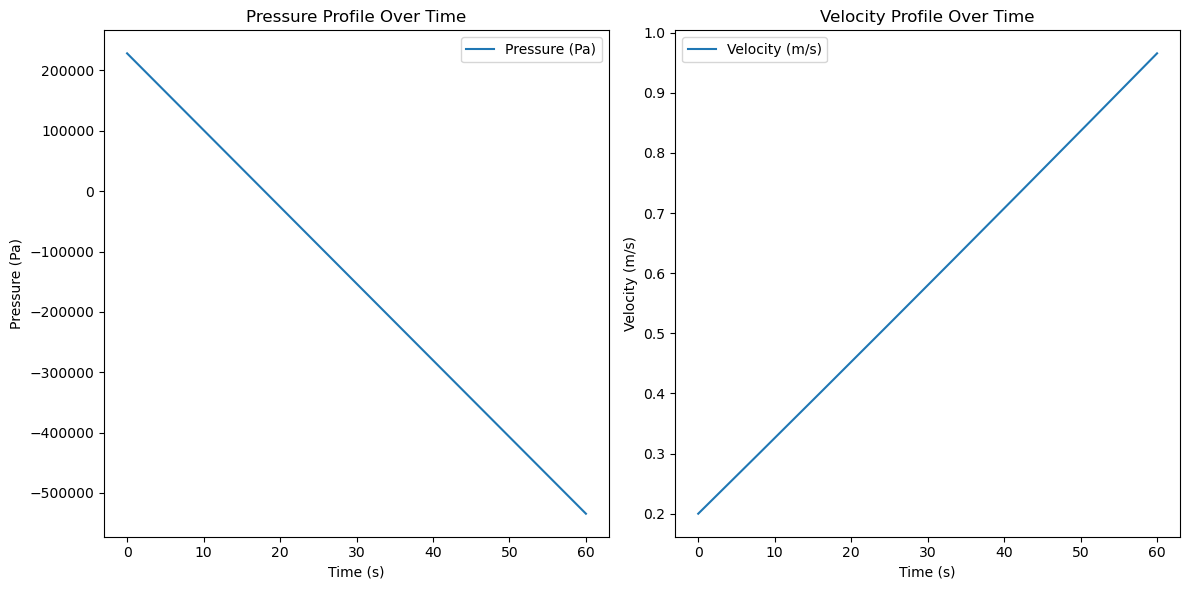

In [1]:
import numpy as np
from scipy.integrate import odeint

# Constants and parameters from the paper
rho = 1294  # fluid density in kg/m^3
tau_0 = 3.4  # yield value in Pa
K = 0.17  # consistency coefficient in Pa.s^n
n = 0.74  # flow behavior index
D_hy = 0.2127  # hydraulic diameter in meters from hole diameter
v = 0.2  # flow velocity in m/s (example value)
g = 9.81  # gravitational acceleration in m/s^2
theta = 0  # well inclination, assumed vertical for simplification

# Equation for shear stress using the Herschel-Bulkley model
def tau(gamma_dot):
    return tau_0 + K * (gamma_dot ** n)

# Differential equations setup
def model(y, t):
    p, v = y  # pressure and velocity
    dpdz = -rho * g * np.cos(theta) - tau(v) / D_hy  # simplified motion equation
    dvdz = (1 / rho) * (-dpdz - rho * g * np.cos(theta))  # continuity equation simplified
    return [dpdz, dvdz]

# Initial conditions: p0 = atmospheric pressure + hydrostatic pressure, v0 = initial flow velocity
p0 = 101325 + rho * g * 10  # Assume well starts at 10m depth
v0 = v  # starting flow velocity
initial_conditions = [p0, v0]

# Time span for the simulation
t = np.linspace(0, 60, 600)  # simulate for 60 seconds, 600 steps

# Solve the system of equations
results = odeint(model, initial_conditions, t)

# Extracting results
pressure = results[:, 0]
velocity = results[:, 1]

# Plot results using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, pressure, label='Pressure (Pa)')
plt.title('Pressure Profile Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, velocity, label='Velocity (m/s)')
plt.title('Velocity Profile Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.tight_layout()
plt.show()
